# Linear Regression and Coulomb's Law

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/elmag.ipynb)

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.


**What is Coulomb's Law?**

Coulomb's law relates the force between two point charges.

$$ F = k \frac{q_1 q_2}{r^2} $$

where $F$ is the force (N), $q_1$ and $q_2$ are the magnitudes of the charges (C), $r$ is the distance between the charges (m),  $k$ is Coulomb's constant (~8.98 x 10^9 Nm^2/C^2).

How was it discovered?

**The aim of the notebook**

In this notebook, we are going to explore how data science can help us to more rigorously understand physical phenomena by using synthetic data with predefined noise parameters. This can help us test the robustness of our models without needing to collect experimental data as well as be able to better explain the predictions our models make in the real world.


## Simulating Data

Firstly, we're going to explore how we can use existing libraries to generate synthetic data. This is an easy way to explore how our models behave under uncertainty in our input data. In other words, we can generate synthetic data to model uncertainty that might arise in experiments and build our models in a way that is robust. We can also use this technique to get a better understanding of the laws we are simulating, particularly when exploring well known physical concepts (such as Coulomb's law).

The function `random_y_kx` will generate a tuple of numbers `x` and `y` with stochastic linear dependence of `y` on `x`. We're going to use this to model the force-charge relationship in Coulomb's law (with a constant representing one fixed charge and a fixed distance between charges). We'll generate these samples from two normal distributions with respective mean and standard deviation and we're going to add a noise parameter to reflect the uncertainty in real world measurements.

In [ ]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install numpy
# ! pip install scikit-learn
# ! pip install matplotlib

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [81]:
def random_y_kx(mean_x=0, sigma_x=1, mean_noise=0, sigma_noise=1, size=1, k=1):
    x = np.random.normal(mean_x, sigma_x, size)
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * x + noise
    return x, y

The function `random_y_kx` creates noisy data based on the relation $y=kx+\eta$ where $\eta$ is a noise parameter.

We can now use this function to generate our first synthetic dataset.

In [91]:
data = []
for i in range(50):
    data.append(random_y_kx(sigma_noise=0.2))
    
x = []
y = []
for i in data:
    x.append(i[0][0])
    y.append(i[1][0])

The above code is just a simple loop that calls the `random_y_kx` function and appends the data to a list object so that we can inspect it further (which is what we're going to do now).

In [92]:
def plot_xy(x, y, title=None, xlabel=None, ylabel=None):
    plt.plot(x, y, 'o')
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.show()

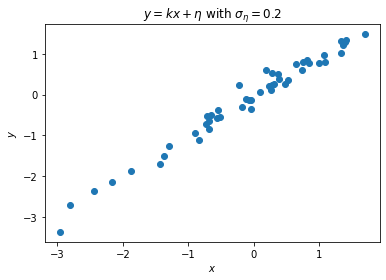

In [93]:
plot_xy(x, y, title="$y=kx+\eta$ with $\sigma_{\eta}=0.2$", xlabel="$x$", ylabel="$y$")

The plot above shows a noisy linear relationship as expected. We've condensed the above code down to the `plot_sample` function, we encourage you to play with different parameters for the noise distribution.

In [94]:
def plot_sample(num_points=50, mean_noise=0, sigma_noise=1, size=1):
    data = []
    for i in range(num_points):
        data.append(random_y_kx(mean_noise=mean_noise, sigma_noise=sigma_noise, size=size)) 
    _x = []
    _y = []
    for i in data:
        _x.append(i[0][0])
        _y.append(i[1][0])

    plot_xy(_x, _y)

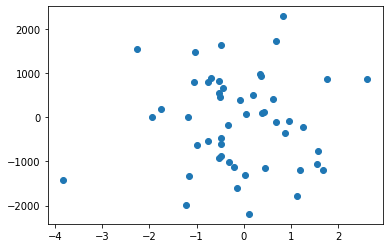

In [95]:
plot_sample(sigma_noise=1000)

Some questions to consider:

* What happens when you increase the standard deviation of the noise distribution?
* What happens when you make it really precise?

## Modelling with Simulated Data

Now that we have our data, it's time to create a model that will tell us some new information. In particular, we would like to know the optimal mathematical relationship that fits our data. Since we can see our data is more or less linear (educated guess, something we'd likely be doing with real-world data as well), we can try a simple linear regression model.

Linear regression is often used to model data that is assumed to have a linear relationship. While very simple, linear regression is quite good at finding a linear relationship when our data has random Gaussian noise (which is pretty close to what we have produced).

To create a linear regression model, we can use the `scikit-learn` library.

In [96]:
model = LinearRegression()

In [97]:
# to be able to use our data with the model, we need to convert it into numpy arrays
x_arr = np.array(x)
y_arr = np.array(y)

In [98]:
model.fit(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))

LinearRegression()

We can now evaluate our model using a score function. For simple linear regression, it is common to use the $R^2$ score function (also called the "coefficient of determination"). The $R^2$ score function tells us how predictable our `y` data is given `x` by considering the variance of the data distribution.

In [99]:
r_sq = model.score(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
print(f"Coefficient of determination: {r_sq}")
print(f"Intercept: {model.intercept_[0]}")
print(f"Slope: {model.coef_[0][0]}")

Coefficient of determination: 0.9767678070877067
Intercept: -0.04887248392029221
Slope: 0.9831121174267548


In this case, the model seems to fit really well to our synthetic data. Some ideas for experimentation:
* What happens to the coefficient of determination when we add more noise parameters to our data generating function? (Consider adding `k` to the function explicitly and sample from a normal distribution)
* How does changing $\eta$ change the results of our linear regression model?

## Non-linear regression

The above can be considered the very simplest example of data science possible, since we're really just fitting a line to linear data. Let's make this task a bit more challenging and consider the force-distance relationship in Coulomb's law.

As before, we'll develop a data generating function that we can use to create a synthetic dataset of force-distance values. In this case, the relation we'll be modeling is $y=\frac{k}{x^2}$, where $k$ represents the constant product of charges (and the Coulomb constant), and $x$ represents the separation between charges.

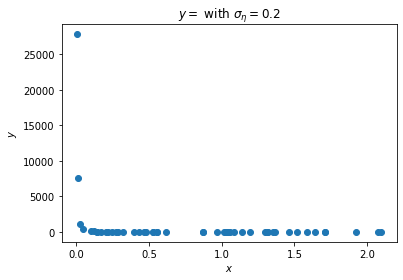

In [119]:
def random_y_kx2(mean_x=0, sigma_x=1, mean_noise=0, sigma_noise=1, size=1, k=1):
    x = np.abs(np.random.normal(mean_x, sigma_x, size))
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * (x**(-2)) + noise
    return x, y

data = []
for i in range(50):
    data.append(random_y_kx2(sigma_noise=0.2))
    
x = []
y = []
for i in data:
    x.append(i[0][0])
    y.append(i[1][0])

plot_xy(x, y, title="$y=\frac{k}{x^2}+\eta$ with $\sigma_{\eta}=0.2$", xlabel="$x$", ylabel="$y$")

We can see that our data is clearly not linear, so linear regression is probably not the best choice of a model. The options here are as follows: either we find a different model that can handle non-linear data or we can do some data processing to make it better suited for a linear model. Here, we're going to take the latter approach.

In [120]:
x_transformed = np.c_[1 / np.square(x)]

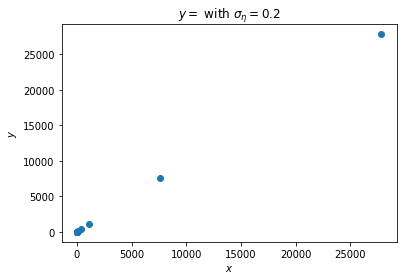

In [121]:
plot_xy(x_transformed, y, title="$y=\frac{k}{x^2}+\eta$ with $\sigma_{\eta}=0.2$", xlabel="$x$", ylabel="$y$")

Here, we have essentially inverted the generated `x` to linearize the relationship between `x` and `y`. In doing so, we made it possible to use the same linear regression model to analyse the relationship between `y` and `x`. Note that we used the knowledge of Coulomb's law to make this linearization, so this would not be so easy if you didn't know the law that generated your data in real-world experiments, however, if the data looks something like that used in this notebook, a simple guess and subsequent trial and error can get you a long way towards better understanding your data.

In [122]:
x_arr = np.array(x_transformed)
y_arr = np.array(y)

In [123]:
model = LinearRegression()
model.fit(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
r_sq = model.score(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
print(f"Coefficient of determination: {r_sq}")
print(f"Intercept: {model.intercept_[0]}")
print(f"Slope: {model.coef_[0][0]}")

Coefficient of determination: 0.9999999974952841
Intercept: 0.013232184287971904
Slope: 0.9999848813211937


If you wish to get an overview of the remaining topics in this course, click the button below.

[![Back to main website](../media/back4.png)](https://physdata.vercel.app/)
